In [1]:
!pip install dist/blitz_env-0.1.0-py3-none-any.whl

Processing ./dist/blitz_env-0.1.0-py3-none-any.whl
blitz-env is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from blitz_env.simulate_draft_sqlite import simulate_draft, visualize_draft_board, DB_URL
from blitz_env.models import DatabaseManager, Player

def draft_player() -> str:
    db = DatabaseManager(DB_URL)
    try:
        # First, try to get the best available QB
        best_qb = db.session.query(Player).filter(
            Player.availability == 'AVAILABLE',
            Player.position == 'QB'
        ).order_by(Player.rank).first()
        
        if best_qb:
            return best_qb.id
        
        # If no QBs available, get best overall player
        best_player = db.session.query(Player).filter(
            Player.availability == 'AVAILABLE'
        ).order_by(Player.rank).first()
        
        return best_player.id if best_player else ""
    finally:
        db.close()

# Run the draft simulation - data is stored in SQLite database
simulate_draft(draft_player, 2025)

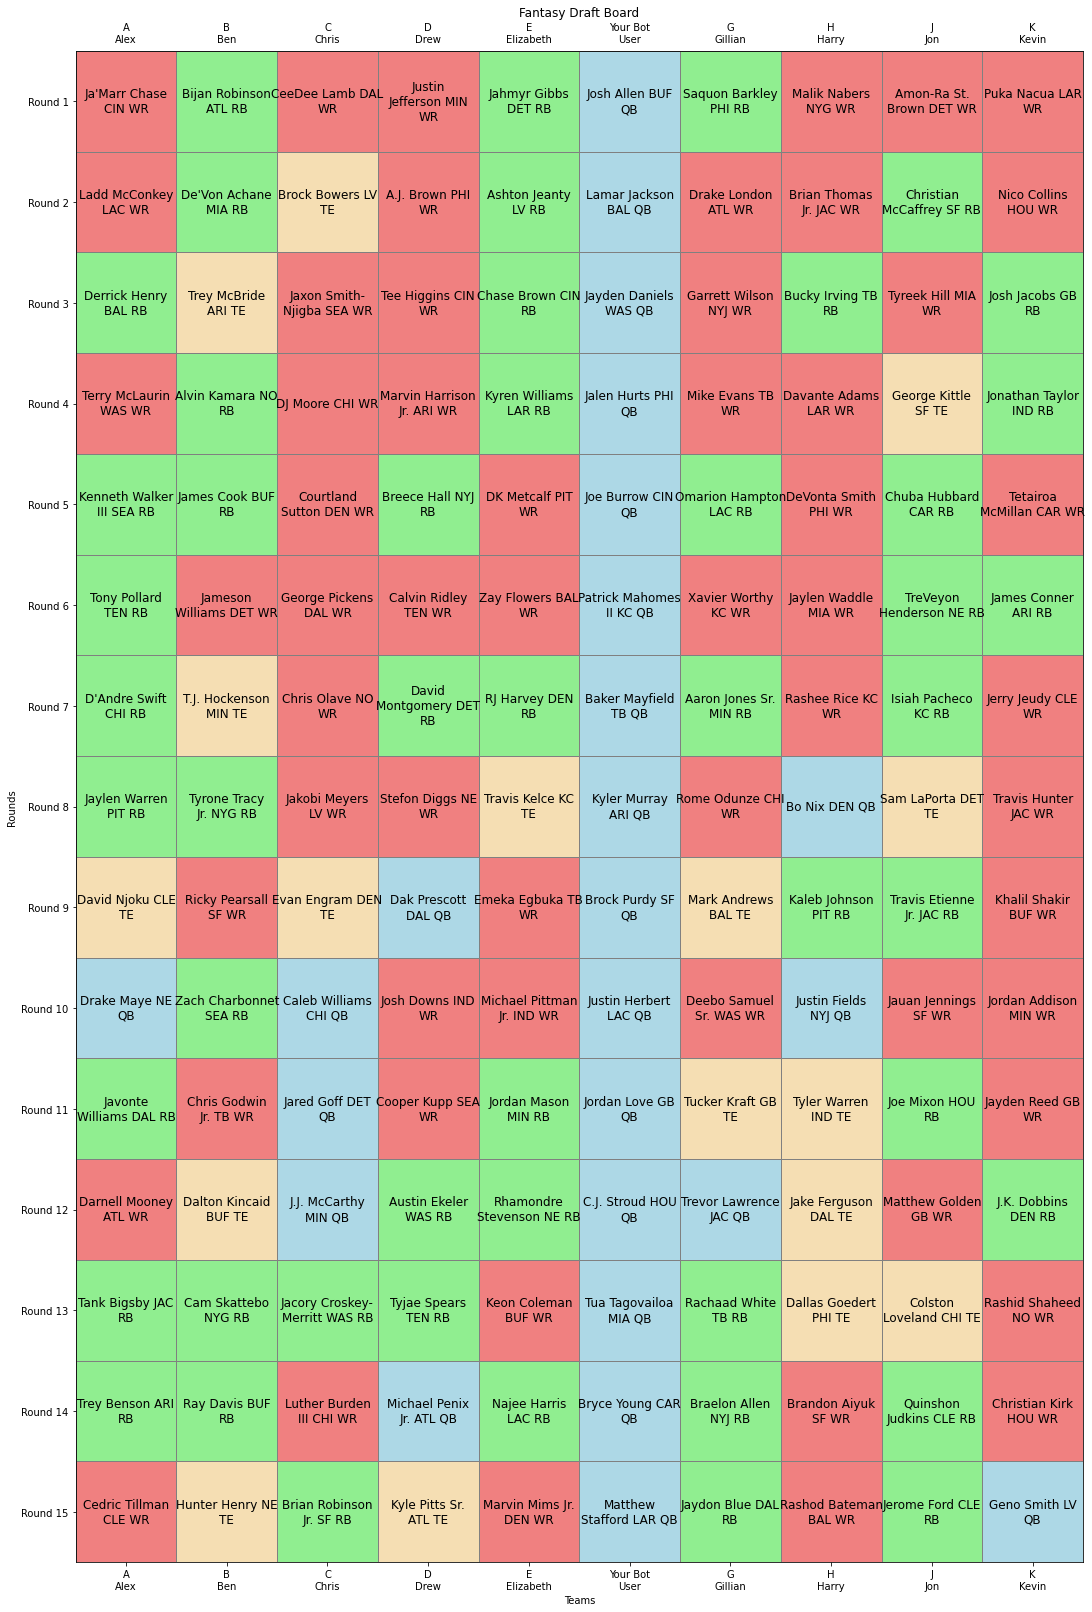

In [3]:
visualize_draft_board()